In [66]:
%load_ext lab_black

The lab_black extension is already loaded. To reload it, use:
  %reload_ext lab_black


In [67]:
%config Completer.use_jedi = False

In [93]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import time
from contextlib import contextmanager
from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split, KFold, GroupKFold
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import QuantileTransformer, StandardScaler
from sklearn.mixture import GaussianMixture

from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from ngboost import NGBRegressor

In [69]:
@contextmanager
def timer(logger=None, format_str="{:.3f}[s]", prefix=None, suffix=None):
    if prefix:
        format_str = str(prefix) + format_str
    if suffix:
        format_str = format_str + str(suffix)
    start = time.time()
    yield
    d = time.time() - start
    out_str = format_str.format(d)
    if logger:
        logger.info(out_str)
    else:
        print(out_str)

In [70]:
path = "input"

In [71]:
train = pd.read_csv(path + "/train.csv", index_col=["id"])
test = pd.read_csv(path + "/test.csv", index_col=["id"])
submission = pd.read_csv(path + "/sample_submission.csv", index_col=["id"])

In [72]:
features = [
    "cont1",
    "cont2",
    "cont3",
    "cont4",
    "cont5",
    "cont6",
    "cont7",
    "cont8",
    "cont9",
    "cont10",
    "cont11",
    "cont12",
    "cont13",
    "cont14",
]

In [73]:
X = train[features]
y = train["target"]

In [76]:
def rmse_score(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

## LightGBM

In [99]:
def fit_lgb(X, y, cv, params: dict = None, verbose: int = 100):
    if params is None:
        params = {}

    models = []
    oof_pred = np.zeros_like(y, dtype=np.float)

    for i, (train_idx, valid_idx) in tqdm(enumerate(cv), total=len(cv)):
        X_train, y_train = X[train_idx], y[train_idx]
        X_valid, y_valid = X[valid_idx], y[valid_idx]

        model = LGBMRegressor(**params)

        with timer(prefix=f"fit fold={i+1}"):
            model.fit(
                X=X_train,
                y=y_train,
                eval_set=[(X_train, y_train), (X_valid, y_valid)],
                eval_names=["Train", "Valid"],
                eval_metric="rmse",
                early_stopping_rounds=verbose,
                verbose=verbose,
            )

        y_pred_i = model.predict(X[valid_idx])
        oof_pred[valid_idx] = y_pred_i
        models.append(model)

        print(f"Fold {i+1} RMSE: {rmse_score(y[valid_idx], y_pred_i):.4f}")

    score = rmse_score(y, oof_pred)
    print(f"FINISEHD | Whole RMSE: {score:.4f}")

    return oof_pred, models

In [100]:
seed = 3665

lgb_params = {
    "objective": "regression",
    "metric": "rmse",
    "learning_rate": 0.05,
    #     "num_leaves": 256,
    #     "max_depth": -1,
    "n_estimators": 5_000,
    "importance_type": "gain",
    "random_state": seed,
}

kfold = KFold(n_splits=5, shuffle=True, random_state=seed)

cv = list(kfold.split(X))

In [101]:
oof_pred, models = fit_lgb(X.values, y.values, cv, lgb_params)

  0%|          | 0/5 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	Train's rmse: 0.702288	Valid's rmse: 0.707928
[200]	Train's rmse: 0.694578	Valid's rmse: 0.703876
[300]	Train's rmse: 0.689796	Valid's rmse: 0.702506
[400]	Train's rmse: 0.68558	Valid's rmse: 0.701763
[500]	Train's rmse: 0.681751	Valid's rmse: 0.701222
[600]	Train's rmse: 0.678121	Valid's rmse: 0.700887
[700]	Train's rmse: 0.674713	Valid's rmse: 0.700651
[800]	Train's rmse: 0.671375	Valid's rmse: 0.700443
[900]	Train's rmse: 0.668099	Valid's rmse: 0.700353
[1000]	Train's rmse: 0.665127	Valid's rmse: 0.700291
[1100]	Train's rmse: 0.66203	Valid's rmse: 0.700171
[1200]	Train's rmse: 0.659044	Valid's rmse: 0.700186
Early stopping, best iteration is:
[1106]	Train's rmse: 0.661843	Valid's rmse: 0.700156
fit fold=16.925[s]
Fold 1 RMSE: 0.7002
Training until validation scores don't improve for 100 rounds
[100]	Train's rmse: 0.703369	Valid's rmse: 0.703944
[200]	Train's rmse: 0.695572	Valid's rmse: 0.700065
[300]	Train's rmse: 

In [102]:
def visualize_importance(models, X, importance_type="gain"):
    feature_importance_df = pd.DataFrame()

    for i, model in enumerate(models):
        _df = pd.DataFrame()
        _df["feature_importance"] = model.feature_importances_
        _df["column"] = X.columns
        _df["fold"] = i + 1
        feature_importance_df = pd.concat(
            [feature_importance_df, _df], axis=0, ignore_index=True
        )

    order = (
        feature_importance_df.groupby("column")
        .sum()[["feature_importance"]]
        .sort_values("feature_importance", ascending=False)
        .index[:50]
    )

    fig, ax = plt.subplots(figsize=(max(6, len(order) * 0.4), 7))
    sns.boxenplot(
        data=feature_importance_df,
        x="column",
        y="feature_importance",
        order=order,
        ax=ax,
        palette="viridis",
    )
    ax.tick_params(axis="x", rotation=90)
    ax.grid()
    fig.tight_layout()
    return fig, ax

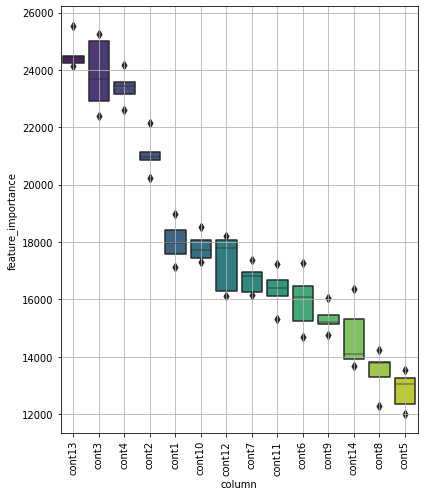

In [103]:
visualize_importance(models, X)

plt.show()

In [90]:
pred = np.array([model.predict(test) for model in models])
pred = np.mean(pred, axis=0)

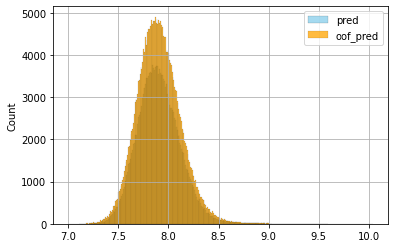

In [91]:
sns.histplot(pred, label="pred", color="skyblue")
sns.histplot(oof_pred, label="oof_pred", color="orange")

plt.legend()
plt.grid(True)
plt.show()

In [92]:
submission["target"] = pred
submission.to_csv("output/submission.csv")

In [114]:
def fit_lgb(X, y, cv, scaler, params: dict = None, verbose: int = 100):
    if params is None:
        params = {}

    models = []
    scalers = []
    oof_pred = np.zeros_like(y, dtype=np.float)

    for i, (train_idx, valid_idx) in tqdm(enumerate(cv), total=len(cv)):
        X_train, y_train = X[train_idx], y[train_idx]
        X_valid, y_valid = X[valid_idx], y[valid_idx]

        model = LGBMRegressor(**params)

        scaled_y_train = scaler.fit_transform(y_train.reshape(-1, 1))[:, 0]
        scaled_y_valid = scaler.transform(y_valid.reshape(-1, 1))[:, 0]

        with timer(prefix=f"fit fold={i+1}"):
            model.fit(
                X=X_train,
                y=scaled_y_train,
                eval_set=[(X_train, scaled_y_train), (X_valid, scaled_y_valid)],
                eval_names=["Train", "Valid"],
                eval_metric="rmse",
                early_stopping_rounds=verbose,
                verbose=100,
            )

        y_pred_i = model.predict(X[valid_idx])
        y_pred_i = scaler.inverse_transform(y_pred_i.reshape(-1, 1))[:, 0]
        oof_pred[valid_idx] = y_pred_i
        models.append(model)
        scalers.append(scaler)

        print(f"Fold {i+1} RMSE: {rmse_score(y[valid_idx], y_pred_i):.4f}")

    score = rmse_score(y, oof_pred)
    print(f"FINISEHD | Whole RMSE: {score:.4f}")

    return oof_pred, models, scalers

In [116]:
seed = 3665

lgb_params = {
    "objective": "regression",
    "metric": "rmse",
    "learning_rate": 0.05,
    "num_leaves": 256,
    #     "max_depth": -1,
    "n_estimators": 5_000,
    "importance_type": "gain",
    "random_state": seed,
}

kfold = KFold(n_splits=5, shuffle=True, random_state=seed)

cv = list(kfold.split(X))

In [117]:
oof_pred, models, scalers = fit_lgb(
    X.values,
    y.values,
    cv,
    QuantileTransformer(output_distribution="normal"),
    lgb_params,
)

  0%|          | 0/5 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	Train's rmse: 0.905615	Valid's rmse: 0.955871
[200]	Train's rmse: 0.865604	Valid's rmse: 0.953719
[300]	Train's rmse: 0.833192	Valid's rmse: 0.953706
Early stopping, best iteration is:
[244]	Train's rmse: 0.850758	Valid's rmse: 0.953554
fit fold=15.477[s]
Fold 1 RMSE: 0.7048
Training until validation scores don't improve for 100 rounds
[100]	Train's rmse: 0.904527	Valid's rmse: 0.947074
[200]	Train's rmse: 0.864815	Valid's rmse: 0.945165
[300]	Train's rmse: 0.832455	Valid's rmse: 0.945255
Early stopping, best iteration is:
[258]	Train's rmse: 0.845728	Valid's rmse: 0.945144
fit fold=25.538[s]
Fold 2 RMSE: 0.7010
Training until validation scores don't improve for 100 rounds
[100]	Train's rmse: 0.90461	Valid's rmse: 0.947799
[200]	Train's rmse: 0.864484	Valid's rmse: 0.945649
[300]	Train's rmse: 0.832863	Valid's rmse: 0.945477
Early stopping, best iteration is:
[280]	Train's rmse: 0.838842	Valid's rmse: 0.945395
fit fold

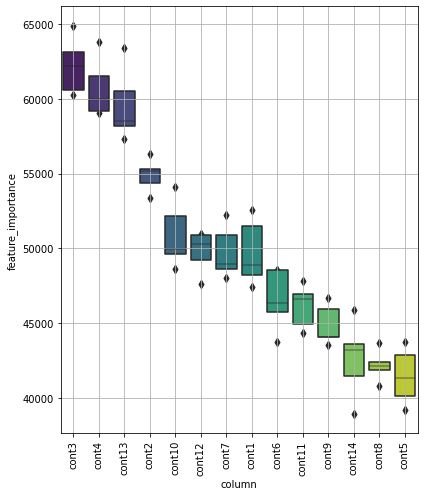

In [118]:
visualize_importance(models, X)

plt.show()

In [108]:
pred = np.array(
    [
        scaler.inverse_transform(model.predict(test).reshape(-1, 1))[:, 0]
        for model, scaler in zip(models, scalers)
    ]
)
pred = np.mean(pred, axis=0)

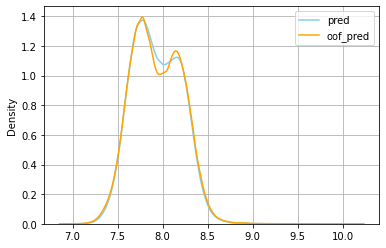

In [109]:
sns.kdeplot(pred, label="pred", color="skyblue")
sns.kdeplot(oof_pred, label="oof_pred", color="orange")

plt.legend()
plt.grid(True)
plt.show()

In [100]:
submission["target"] = pred
submission.to_csv("output/submission.csv")